In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import optax
import gym
import tqdm
import jax
import collections

In [101]:
init_s = 0
size = 5
walls = np.zeros((size, size))
gamma = 0.9

def step(s, a):
    i, j = np.unravel_index(s, walls.shape)
    if a == 0:
        j += 1
    elif a == 1:
        i -= 1
    elif a == 2:
        j -= 1
    elif a == 3:
        i += 1
    else:
        assert a == 4
    if i < 0 or j < 0 or i >= size or j >= size or walls[i, j]:
        return s
    else:
        return np.ravel_multi_index((i, j), walls.shape)

100%|██████████| 10000/10000 [00:00<00:00, 89285.72it/s]


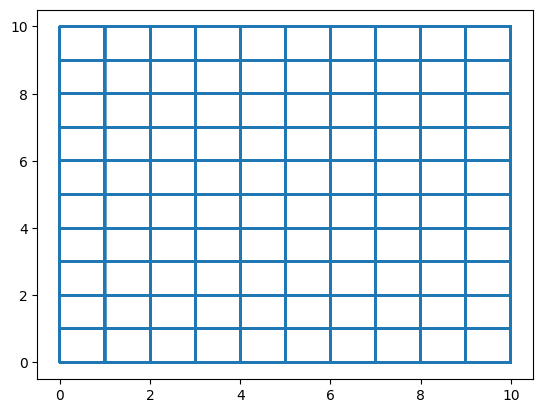

In [102]:
s = init_s
vec = []
for _ in tqdm.trange(10_000):
    vec.append(s)
    s = step(s, np.random.choice(5))
vec = np.array(vec)
i, j = np.unravel_index(vec, walls.shape)
plt.plot(i, j)

100%|██████████| 10000/10000 [00:00<00:00, 24171.40it/s]


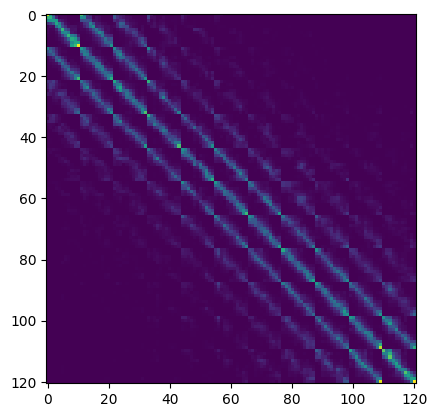

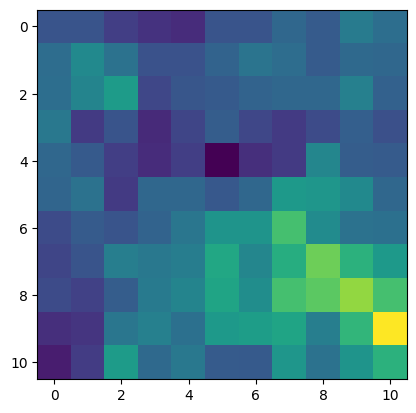

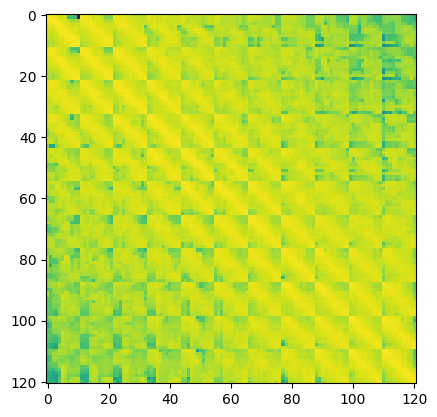

In [104]:
# compute the true empirical discounted state occupancy measure
d = [[] for s in range(size * size)]
sr = jax.nn.one_hot(vec[-1], size*size)
for t in tqdm.trange(len(vec)-1, -1, -1):
    d[vec[t]] = d[vec[t]] + [sr]
    sr = gamma * sr + (1 - gamma) * jax.nn.one_hot(vec[t], size*size)
SR = np.array([np.mean(sr_vec, axis=0) for sr_vec in d])
plt.imshow(SR)
plt.show()

counts = collections.Counter(vec)
marginals = np.array([counts[s] for s in range(size * size)])
marginals = marginals / np.sum(marginals)
plt.imshow(marginals.reshape((size, size)))
plt.show()

log_ratio = jnp.log(SR / marginals[None])
plt.imshow(log_ratio)
plt.show()

100%|██████████| 10000/10000 [00:11<00:00, 881.05it/s]


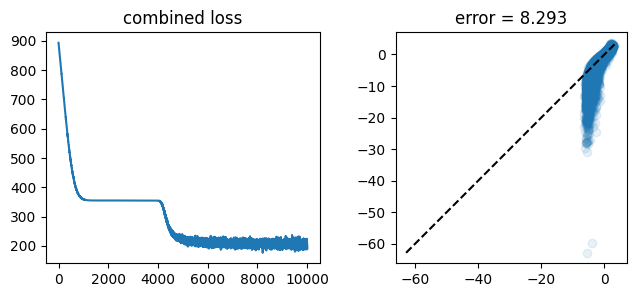

In [108]:
# learn the representations
X = jnp.array(vec)

# Settings that make sense:
# * CS, log_linear=True, repr_activation=False

repr_dim = 64
batch_size = 256
loss_type = 'ce'
log_linear = False

repr_activation = False
if loss_type in ['ce', 'sce'] and not log_linear:
    # If we want to use the linear parametrization with the CE or softmax CE loss,
    # we apply an elementwise activation to the reps so that the dot product is positive.
    # For the LSIF loss, it's fine if the dot product is neg.
    repr_activation = True

key = jax.random.key(1)
key, rng1, rng2 = jax.random.split(key, 3)
F = 1e-9 * jax.random.normal(rng1, shape=(size * size, repr_dim))
B = 1e-9 * jax.random.normal(rng2, shape=(size * size, repr_dim))
params = (F, B)


I = jnp.eye(batch_size)
optimizer = optax.adam(learning_rate=3e-3)
opt_state = optimizer.init(params)

def get_data(key):
    rng1, rng2 = jax.random.split(key, 2)
    t0 = jax.random.choice(rng1, X.shape[0], (batch_size,))
    delta = jax.random.geometric(rng2, 1 - gamma, (batch_size,))
    t1 = t0 + delta    
    return X[t0], X[t1]

def get_probs(f, b):
    if repr_activation:
        f = jax.nn.softplus(f)
        b = jax.nn.softplus(b)
    probs = jnp.einsum('ik,jk->ij', f, b)
    if log_linear:
        probs = jnp.exp(probs)
    return probs

def loss_fn(params, x0, x1):
    f = params[0][x0]
    b = params[1][x1]
    probs = get_probs(f, b)
    if loss_type == 'ce': # binary cross entropy
        mask = I + (1 - I) / (batch_size - 1)
        loss = mask * optax.sigmoid_binary_cross_entropy(logits=jnp.log(probs), labels=I)
    elif loss_type == 'sce':  # softmax cross entropy
        loss = (optax.softmax_cross_entropy(logits=jnp.log(probs), labels=I) + optax.softmax_cross_entropy(logits=jnp.log(probs.T), labels=I)) / 2.0
    elif loss_type == 'lsif':
        loss = 0.5 * ((1 - I) * probs**2).sum() / (1 - I).sum() - jnp.diag(probs).sum() / I.sum()
        # loss = 0.5 * (probs**2).mean() - jnp.diag(probs).mean()
    else:
        raise NotImplementedError
    return loss.sum()
grad_fn = jax.value_and_grad(loss_fn)

@jax.jit
def step_fn(params, opt_state, key):
    key, rng = jax.random.split(key, 2)
    x0, x1 = get_data(rng)
    loss, grad = grad_fn(params, x0, x1)
    updates, opt_state = optimizer.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state, key

loss_vec = []
for _ in tqdm.trange(10_000):
    key, rng = jax.random.split(key)
    loss, params, opt_state, key = step_fn(params, opt_state, key)
    loss_vec.append(loss)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('combined loss')
plt.plot(loss_vec)
plt.subplot(132)

# compute the error
f = params[0]
b = params[1]
logits = jnp.log(get_probs(f, b))
if loss_type == 'sce':
    logits = jax.nn.log_softmax(logits, axis=1) + jnp.log(size*size)  # This only works if dataset coverage is uniform

plt.plot(logits.flatten(), log_ratio.flatten(), 'o', alpha=0.1)
plt.plot([log_ratio.min(), log_ratio.max()],
         [log_ratio.min(), log_ratio.max()], 'k--')
plt.gca().set_aspect('equal')
error = np.nanmean((logits - log_ratio)**2)
plt.title('error = %.3f' % error)
plt.show()


100%|██████████| 10000/10000 [00:07<00:00, 1402.17it/s]


4 ce True 0.22298686


100%|██████████| 10000/10000 [00:08<00:00, 1142.57it/s]


4 sce True 0.23726133


100%|██████████| 10000/10000 [00:04<00:00, 2291.96it/s]


4 lsif True 1.180733


100%|██████████| 10000/10000 [00:07<00:00, 1379.87it/s]


4 ce False 0.24991496


100%|██████████| 10000/10000 [00:09<00:00, 1094.10it/s]


4 sce False 0.3050672


100%|██████████| 10000/10000 [00:03<00:00, 2513.21it/s]


4 lsif False 0.44824272


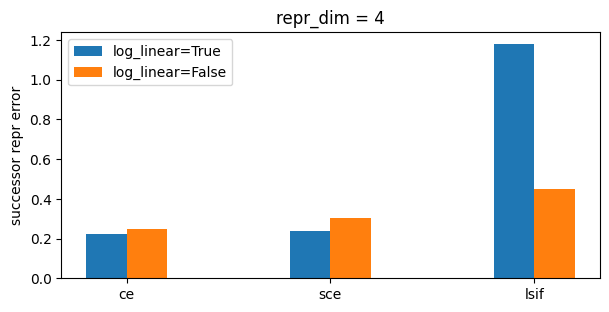

In [92]:
# learn the representations
X = jnp.array(vec)

def get_error(repr_dim, loss_type, log_linear):
    repr_activation = False
    if loss_type in ['ce', 'sce'] and not log_linear:
        # If we want to use the linear parametrization with the CE or softmax CE loss,
        # we apply an elementwise activation to the reps so that the dot product is positive.
        # For the LSIF loss, it's fine if the dot product is neg.
        repr_activation = True

    key = jax.random.key(0)
    key, rng1, rng2 = jax.random.split(key, 3)
    F = 1e-6 * jax.random.normal(rng1, shape=(size * size, repr_dim))
    B = 1e-6 * jax.random.normal(rng2, shape=(size * size, repr_dim))
    params = (F, B)
    
    
    I = jnp.eye(batch_size)
    optimizer = optax.adam(learning_rate=3e-3)
    opt_state = optimizer.init(params)
    
    def get_data(key):
        rng1, rng2 = jax.random.split(key, 2)
        t0 = jax.random.choice(rng1, X.shape[0], (batch_size,))
        delta = jax.random.geometric(rng2, 1 - gamma, (batch_size,))
        t1 = t0 + delta    
        return X[t0], X[t1]
    
    def get_probs(f, b):
        if repr_activation:
            f = jax.nn.softplus(f)
            b = jax.nn.softplus(b)
        probs = jnp.einsum('ik,jk->ij', f, b)
        if log_linear:
            probs = jnp.exp(probs)
        return probs
    
    def loss_fn(params, x0, x1):
        f = params[0][x0]
        b = params[1][x1]
        probs = get_probs(f, b)
        if loss_type == 'ce': # binary cross entropy
            mask = I + (1 - I) / (batch_size - 1)
            loss = mask * optax.sigmoid_binary_cross_entropy(logits=jnp.log(probs), labels=I)
        elif loss_type == 'sce':  # softmax cross entropy
            loss = (optax.softmax_cross_entropy(logits=jnp.log(probs), labels=I) + optax.softmax_cross_entropy(logits=jnp.log(probs.T), labels=I)) / 2.0
        elif loss_type == 'lsif':
            loss = 0.5 * ((1 - I) * probs**2).sum() / (1 - I).sum() - jnp.diag(probs).sum() / I.sum()
            # loss = 0.5 * (probs**2).mean() - jnp.diag(probs).mean()
        else:
            raise NotImplementedError
        return loss.sum()
    grad_fn = jax.value_and_grad(loss_fn)
    
    @jax.jit
    def step_fn(params, opt_state, key):
        key, rng = jax.random.split(key, 2)
        x0, x1 = get_data(rng)
        loss, grad = grad_fn(params, x0, x1)
        updates, opt_state = optimizer.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state, key
    
    loss_vec = []
    for _ in tqdm.trange(10_000):
        key, rng = jax.random.split(key)
        loss, params, opt_state, key = step_fn(params, opt_state, key)
        loss_vec.append(loss)
    
    # plt.figure(figsize=(12, 3))
    # plt.subplot(131)
    # plt.title('combined loss')
    # plt.plot(loss_vec)
    # plt.subplot(132)
    
    # # compute the error
    f = params[0]
    b = params[1]
    logits = jnp.log(get_probs(f, b))
    if loss_type == 'sce':
        logits = jax.nn.log_softmax(logits, axis=1) + jnp.log(size*size)  # This only works if dataset coverage is uniform
    error = np.nanmean((logits - log_ratio)**2)
    # plt.plot(logits.flatten(), log_ratio.flatten(), 'o', alpha=0.1)
    # plt.plot([log_ratio.min(), log_ratio.max()],
    #          [log_ratio.min(), log_ratio.max()], 'k--')
    # plt.gca().set_aspect('equal')
    # plt.title('error = %.3f' % error)
    # plt.show()
    return error


repr_dim = 4
batch_size = 256
# loss_type = 'sce'
# log_linear = False
plt.figure(figsize=(6, 3))
# repr_dim_vec = [4, 16, 64, 256]
x = np.arange(3)
loss_type_vec = ['ce', 'sce', 'lsif']
width = 0.2
for col, log_linear in enumerate([True, False]):
    error_vec = []
    for loss_type in loss_type_vec:
        error = get_error(repr_dim, loss_type, log_linear)
        print(repr_dim, loss_type, log_linear, error)
        error_vec.append(error)
    plt.bar(x - width / 2 if col == 0 else x + width / 2,
            error_vec, width=width, label='log_linear=%s' % log_linear)
    plt.xticks(x, loss_type_vec)
plt.legend()
plt.tight_layout()
# plt.xlabel('repr_dim')
plt.ylabel('successor repr error')
plt.title('repr_dim = %s' % (repr_dim,))
plt.savefig('fig.png', dpi=300)
plt.show()